In [38]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [39]:
class DecisionStump:
    def __init__(self):
        self.polarity = 1
        self.feature_idx = None
        self.threshold = None
        self.alpha = None

    def predict(self, X):
        n_samples = X.shape[0]
        X_column = X[:, self.feature_idx]

        predictions = np.ones(n_samples)

        if self.polarity == 1:
            predictions[X_column<self.threshold] = -1
        else:
            predictions[X_column>self.threshold] = -1
        return predictions

In [40]:
class AdaBoost:
    def __init__(self, n_clf=5):
        self.n_clf = n_clf

    def fit(self, X, y):
        n_samples, n_features = X.shape

        w = np.full(n_samples, (1/n_samples))

        self.clfs = []

        for _ in range(self.n_clf):
            clf = DecisionStump()

            min_error = float('inf')
            best_error = None  

            for feature_i in range(n_features):
                X_column = X[:, feature_i]
                thresholds = np.unique(X_column)

                for threshold in thresholds:
                    p = 1
                    predictions = np.ones(n_samples)
                    predictions[X_column < threshold] = -1

                    missclassified = w[y != predictions]
                    error = sum(missclassified)

                    if error > 0.5:
                        error = 1 - error
                        p = -1
                    
                    if error < min_error:
                        min_error = error
                        best_error = error
                        clf.polarity = p
                        clf.threshold = threshold
                        clf.feature_idx = feature_i
            
            EPS = 1e-8
            
            clf.alpha = 0.5 * np.log((1 - best_error) / (best_error + EPS))

            predictions = clf.predict(X)

            w *= np.exp(-clf.alpha * y * predictions)
            w /= np.sum(w)

            self.clfs.append(clf)

    def predict(self, X):
        clf_preds = [clf.alpha * clf.predict(X) for clf in self.clfs]

        y_pred = np.sum(clf_preds, axis=0)
        y_pred = np.sign(y_pred)

        return y_pred

In [41]:
data = load_breast_cancer()
X = data.data
y = data.target

y[y==0] = -1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=56)

In [42]:
clf = AdaBoost(n_clf=30)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

Accuracy: 0.956140350877193
              precision    recall  f1-score   support

          -1       0.92      0.98      0.95        46
           1       0.98      0.94      0.96        68

    accuracy                           0.96       114
   macro avg       0.95      0.96      0.95       114
weighted avg       0.96      0.96      0.96       114



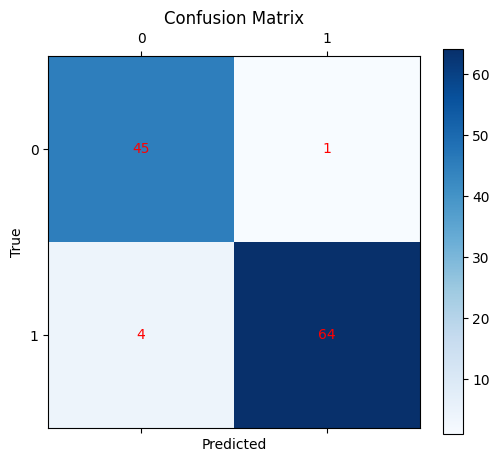

In [43]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(6, 5))
cax = ax.matshow(cm, cmap='Blues')
fig.colorbar(cax)
for (i, j), val in np.ndenumerate(cm):
    ax.text(j, i, val, ha='center', va='center', color='red')
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Confusion Matrix')
plt.show()